<a href="https://colab.research.google.com/github/clemencia/ML4PPGF_UERJ/blob/master/LSTM_Keras_stockprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# LSTM implemented in Keras for Stock Prediction (Time Series)

### Informação sobre tratamento dos dados para este notebook:

https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944




In [1]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# mount Google Drive to access Data
!fusermount -u drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!ls "gdrive/My Drive/Colab Notebooks/Data"

# Get NASDAQ data ( https://finance.yahoo.com/quote/GOOG/history/ ) and print 
stock_data = pd.read_csv("gdrive/My Drive/Colab Notebooks/Data/GOOG.csv")
stock_data.info()

fusermount: failed to unmount /content/drive: No such file or directory
Mounted at /content/gdrive
GOOG.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
Date         1258 non-null object
Open         1258 non-null float64
High         1258 non-null float64
Low          1258 non-null float64
Close        1258 non-null float64
Adj Close    1258 non-null float64
Volume       1258 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


**We will take the average of the low and high of the Google stock for the day and volume of the stocks traded for the day to predict the stock prices.**

In [2]:
import math

# take the average of the low and high of the Google stock for the day
stock_data["average"] = (stock_data["High"] + stock_data["Low"])/2
print(stock_data.head())





         Date        Open        High  ...   Adj Close   Volume     average
0  2014-09-26  574.482788  577.664001  ...  575.519897  1443600  575.375305
1  2014-09-29  570.184570  576.606934  ...  574.781921  1282400  573.106537
2  2014-09-30  575.350403  578.262390  ...  575.779175  1621700  574.771972
3  2014-10-01  574.432922  575.998596  ...  566.714111  1445400  570.728058
4  2014-10-02  565.756714  570.344116  ...  568.519104  1178400  566.060882

[5 rows x 8 columns]


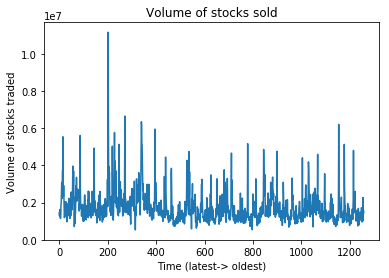

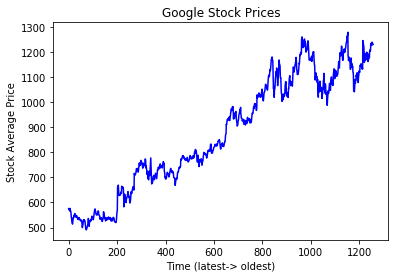

In [3]:
import copy
# take the volume and average stock price as our input features and store it in input_data
input_feature= stock_data.iloc[:,[6,7]].values
input_data = copy.copy(input_feature)

# plot the data for volume for the Google stocks traded for the day
plt.plot(input_feature[:,0])
plt.title("Volume of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Volume of stocks traded")
plt.show()


# plot the data for the average price for the day the Google stock
plt.plot(input_feature[:,1], color='blue')
plt.title("Google Stock Prices")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Average Price")
plt.show()




Aplicamos uma transformação para escalar os valores



In [4]:
# Normalizing the input data using MinMaxScaler so that all the input features are on the scale from 0 to 1
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
input_data[:,0:2] = sc.fit_transform(input_feature[:,:])
print(input_data[0:3])

[[0.08614644 0.10789684]
 [0.07099279 0.10501536]
 [0.10288878 0.10713057]]


**The time series data for today should contain the [Volume of stocks traded, Average stock price] for past 50 days and the target variable will be Google’s stock price today and so on. As the stock price prediction is based on multiple input features, it is a multivariate regression problem.**

In [0]:
lookback= 50

test_size=int(.3 * len(stock_data))
X=[]
y=[]
for i in range(len(stock_data)-lookback-1):
    t=[]
    for j in range(0,lookback):
        
        t.append(input_data[[(i+j)], :])
    X.append(t)
    y.append(input_data[i+ lookback,1])


**LSTM expects the input data in a specific 3D format of test sample size, time steps, no. of input features. In our case timesteps is 50, number of input features is 2(volume of stocks traded and the average stock price).**

In [6]:
X, y= np.array(X), np.array(y)
X_test = X[len(stock_data) - test_size:-1]
y_test =  y[len(stock_data) - test_size: -1 ]
X_train = X[0:len(stock_data)-test_size]
y_train = y[0:len(stock_data)-test_size]
X_train= X_train.reshape(X_train.shape[0],lookback, 2)
X_test = X_test.reshape(X_test.shape[0],lookback, 2)
print(X_train.shape)
print(X_test.shape)
#check primeiro elemento de teste e ultimo elemento do treino
print(X[len(stock_data)-test_size][0],X_test[0][0],X_train[-1][0],X[len(stock_data)-test_size-1][0])

(881, 50, 2)
(325, 50, 2)
[[0.26717242 0.65029061]] [0.26717242 0.65029061] [0.24141497 0.68641697] [[0.24141497 0.68641697]]


**Build the LSTM**

In [7]:
from keras import Sequential
from keras.layers import Dense, LSTM

# define the LSTM architecture 
model = Sequential()
model.add(LSTM(units=50, return_sequences= False, input_shape=(X_train.shape[1],2)))
#model.add(LSTM(units=30, return_sequences=True))
#model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()

# compile 
model.compile(optimizer='adam', loss='mean_squared_error')

# train the network
history = model.fit(X_train, y_train, epochs=10, batch_size=20 , verbose=1 , validation_split=0.2)



Using TensorFlow backend.





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10600     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,651
Trainable params: 10,651
Non-trainable params: 0
_________________________________________________________________

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 704 samples, validate on 177 samples
Epoch 1/10
704/704 [==============================] - 5s 7ms/step - loss: 0.0132 - val_loss: 0.0032
Epoch 2/10
704/704 [==============================] - 4s 5ms/step - loss: 8.7467e-04 - val_loss: 0.0015
Epoch 3/10
704/704 [==============================] - 4s 6ms/step - loss: 6.3224e-04 - val_loss: 0.0016
Epoch 4/10
704/704 [==============================] - 4s 5

**Make predictions and plot performance**

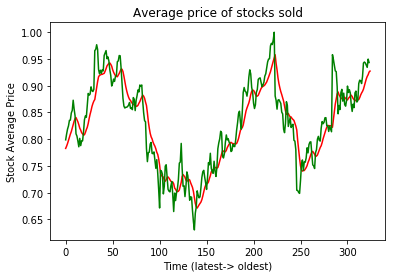

Text(0, 0.5, 'Loss')

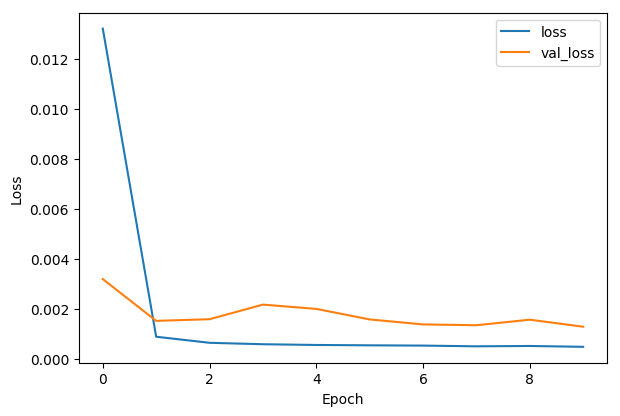

In [8]:
# make predictions
predicted_value= model.predict(X_test)

# plot the predictions
plt.plot(predicted_value, color= 'red')
plt.plot(y_test[:-1], color='green')
plt.title("Average price of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Average Price")
plt.show()

# plot performance
plt.style.use('default')
plt.figure(figsize=(15,10))

ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
#ax.set_ylim([0, 1])
ax.legend(loc="upper right")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')



Do gráfico da "loss function" podemos ver que 5-10 epocas de treino são suficientes.

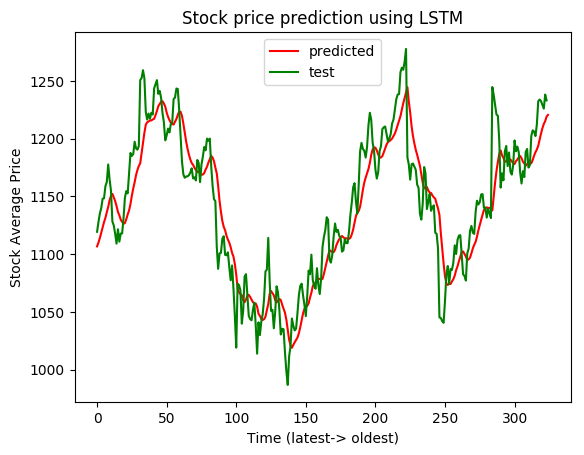

In [9]:


pv =  predicted_value* sc.data_range_[1] + sc.data_min_[1]
yt = y_test*sc.data_range_[1] + sc.data_min_[1]

plt.plot(pv,color="red",label="predicted")
plt.plot(yt[:-1],color="green",label="test")
plt.title("Stock price prediction using LSTM")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Average Price")
plt.legend(loc="upper center")